# Logistic Regression

Logistic regression is a simple machine learning algorithm for classification.
One way to look at it, is as a single neuron that computes the weighted sum of its inputs and outputs an *activation* that turns the weighted sum into a probability.
In this toy example we are going to use it to decide, to which of two distributions a data point belongs.

## Data Generation
First we create two overlapping two-dimensional gaussian distributions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(842424)

In [3]:
nSamples = 1000
inputDim = 2
outputDim = 1

In [4]:
batchSize = 50
nEpochs = 100

In [5]:
x1 = np.random.normal(1., 0.25, (nSamples//2, inputDim))
x2 = np.random.normal(2., 0.30, (nSamples//2, inputDim))
y1 = np.zeros(nSamples//2)
y2 = np.ones(nSamples//2)
x = np.concatenate((x1, x2))
y = np.concatenate((y1, y2))

In [6]:
shuffled = np.arange(nSamples)
np.random.shuffle(shuffled)
xs = x[shuffled]
ys = y[shuffled]

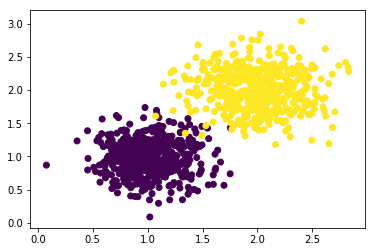

In [7]:
plt.scatter(*zip(*(np.concatenate((x1, x2)))), c=np.concatenate((np.zeros(len(x1)), np.ones(len(x2)))))

## The Logistic Function
The logistic (or sigmoid) function gives the predicted probability of the tested hypothesis being true.
In our case: does the input belong to the yellow distribution?

$$\sigma(z) = \frac{1}{1 + \text{e}^{-z}}$$

The activation function of a neuron is applied to the dot product of the weights of the model and the input.
To optimize the model with a gradient descent optimizer, the activation function has to be differentiable.

In [1]:
def activation(z):
    """Return the sigmoid of input z."""
    return 1 / (1 + np.exp(-z))

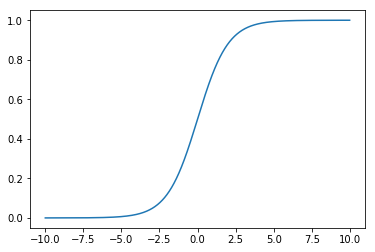

In [9]:
plt.plot(np.arange(-10, 10, 0.01), activation(np.arange(-10, 10, 0.01)))

In [2]:
def lr_predict(weights, x):
    """Return the prediction of the model for input x with the given weights."""
    return activation(np.dot(x, weights))

## The Loss Function

The loss function measures how well the model performs. If the model predicts all samples correctly it would be 0.
For classification cross-entropy loss is usually used.
Here we use Mean Squared Error:

$$ MSE(\textrm{samples}) = \frac{1}{2 |\textrm{samples}|} \sum_{x \in \textrm{samples}} \left(y(x) - y_{\textrm{label}}\right)^2$$

To minimize the loss, we also compute the gradient w.r.t. a single weight.

In [11]:
def lr_loss(weights, x_b, label):
    loss = 0.
    inputDim = x.shape[0]
    grad = np.zeros(inputDim + 1)
    
    y = lr_predict(weights, x_b)
    
    loss = (y - label)**2 / 2
    
    grad = -(y - label) * y**2 * np.exp(-np.dot(weights, x_b)) * x_b
    
    return loss, grad

## Training the Model Manually
To train the model, we now initialize the weights and compute the corresponding loss.
We then update the weights with the gradient of the loss, until the model converges.
Since loss is not a very intuitable quantity, we also print the accuracy (percentage of correctly classified samples).

In [31]:
def lr_train(x, labels, nEpochs, lr=0.001):
    weights = np.random.random(x.shape[1]+1)
    x_b = np.hstack((np.ones((x.shape[0], 1)), x))    
    for epoch in range(nEpochs):
        sumloss = 0.
        accuracy = 0.
        for n in range(nSamples):
            loss, grad = lr_loss(weights, x_b[n], labels[n])
            sumloss += loss
            if int(lr_predict(weights, x_b[n]) + 0.5) == labels[n]:
                accuracy += 1.
            weights += lr * grad

        sumloss /= nSamples
        accuracy /= nSamples
        accuracy *= 100
        if epoch % 10 == 0:
            print(epoch, sumloss, accuracy)
    return weights

In [32]:
weights = lr_train(xs, ys, nEpochs)

0 0.16416009780476423 50.0
10 0.09472582410771953 58.4
20 0.08615277581719152 81.0
30 0.07896082891175117 89.3
40 0.07267255205137026 93.30000000000001
50 0.06717930404541192 95.39999999999999
60 0.062374747187783484 97.39999999999999
70 0.05816149093545755 97.8
80 0.054453726114711505 98.2
90 0.05117756501844079 98.3


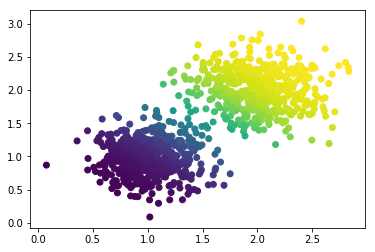

In [16]:
plt.scatter(*zip(*xs), c=[lr_predict(weights, x) for x in np.hstack((np.ones((x.shape[0], 1)), xs))])

## Keras
Building a model can often be simplified with a high level API like Keras.
Our simple model in the Keras vocabulary is defined as a $\texttt{Sequential}$ model with a single $\texttt{Dense}$ layer 
with a sigmoid activation function.

It is then "compiled" with a stochastic gradient descent optimizer and an mse loss.
These parameters can be given by keyword or custom objects. E.g. here the default learning rate of the SGD optimizer is too slow for this simple demonstration.

The training is done with the $\texttt{fit}$ method.


The simplest model in Keras is $\texttt{Sequential}$, a linear stack of layers. The layers can be passed to the constructor as a list, or $\texttt{add}$ed later.

The $\texttt{Dense}$ layer encodes:
$$ f(W \cdot x)$$
where $W \in \mathbb{R}^{\text{outputDim x 1+inputDim}}$, x = (1, $\textrm{input}_1$, .. , $\textrm{input}_{\textrm{inputDim}}$) and f applies the activation function to each element in the resulting vector.
In short: every output is connected to every input plus a constant bias.

Keras also always uses minibatches by default. Why?

In [17]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

Using TensorFlow backend.


In [18]:
model = Sequential()
model.add(Dense(outputDim, input_dim=inputDim, activation='sigmoid'))

In [19]:
sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

In [20]:
fit = model.fit(xs, ys, batch_size=batchSize, epochs=nEpochs)

Epoch 1/100
1000/1000 [==============================] - 0s 150us/step - loss: 0.3438 - acc: 0.4880
Epoch 2/100
1000/1000 [==============================] - 0s 16us/step - loss: 0.2283 - acc: 0.5420
Epoch 3/100
1000/1000 [==============================] - 0s 15us/step - loss: 0.1804 - acc: 0.7600
Epoch 4/100
1000/1000 [==============================] - 0s 19us/step - loss: 0.1499 - acc: 0.9220
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 0.1269 - acc: 0.9650
Epoch 6/100
1000/1000 [==============================] - 0s 17us/step - loss: 0.1094 - acc: 0.9800
Epoch 7/100
1000/1000 [==============================] - 0s 14us/step - loss: 0.0964 - acc: 0.9860
Epoch 8/100
1000/1000 [==============================] - 0s 14us/step - loss: 0.0858 - acc: 0.9850
Epoch 9/100
1000/1000 [==============================] - 0s 20us/step - loss: 0.0777 - acc: 0.9900
Epoch 10/100
1000/1000 [==============================] - 0s 14us/step - loss: 0.0711 - acc: 0.9850
Epoch 11

1000/1000 [==============================] - 0s 18us/step - loss: 0.0162 - acc: 0.9930
Epoch 84/100
1000/1000 [==============================] - 0s 15us/step - loss: 0.0161 - acc: 0.9940
Epoch 85/100
1000/1000 [==============================] - 0s 16us/step - loss: 0.0161 - acc: 0.9930
Epoch 86/100
1000/1000 [==============================] - 0s 19us/step - loss: 0.0160 - acc: 0.9930
Epoch 87/100
1000/1000 [==============================] - 0s 17us/step - loss: 0.0159 - acc: 0.9920
Epoch 88/100
1000/1000 [==============================] - 0s 16us/step - loss: 0.0158 - acc: 0.9930
Epoch 89/100
1000/1000 [==============================] - 0s 16us/step - loss: 0.0157 - acc: 0.9930
Epoch 90/100
1000/1000 [==============================] - 0s 16us/step - loss: 0.0156 - acc: 0.9930
Epoch 91/100
1000/1000 [==============================] - 0s 16us/step - loss: 0.0155 - acc: 0.9930
Epoch 92/100
1000/1000 [==============================] - 0s 15us/step - loss: 0.0154 - acc: 0.9940
Epoch 93/100


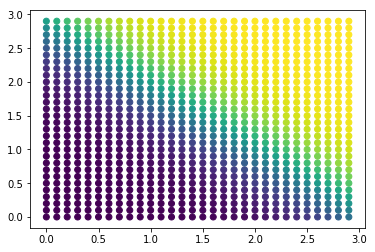

In [21]:
ls = np.zeros((30, 30))
ms = np.zeros((30, 30))
ns = np.zeros((30, 30))
for i in range(30):
    for j in range(30):
        ms[i, j] = i/10
        ns[i, j] = j/10
        ls[i, j] = model.predict(np.array([ms[i, j], ns[i, j]]).reshape((1, 2)))
ms.flatten()
ns.flatten()
ls.flatten()

plt.scatter(ms, ns, c=ls)

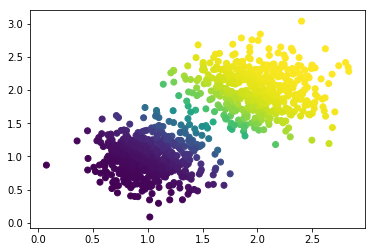

In [22]:
plt.scatter(*zip(*xs), c=model.predict(xs, batchSize).reshape(nSamples, ))

### Bonus:
Why is a simple logistic regression not the optimal solution for this task?

What is the property required of an actual model solution?